In [50]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Download data

In [51]:
!wget http://cogcomp.org/Data/QA/QC/TREC_10.label -O test.label
!wget http://cogcomp.org/Data/QA/QC/train_5500.label -O train.label

--2022-10-24 16:26:15--  http://cogcomp.org/Data/QA/QC/TREC_10.label
Resolving cogcomp.org (cogcomp.org)... 173.236.182.118
Connecting to cogcomp.org (cogcomp.org)|173.236.182.118|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://www.cogcomp.org/Data/QA/QC/TREC_10.label [following]
--2022-10-24 16:26:15--  http://www.cogcomp.org/Data/QA/QC/TREC_10.label
Resolving www.cogcomp.org (www.cogcomp.org)... 173.236.182.118
Reusing existing connection to cogcomp.org:80.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cogcomp.seas.upenn.edu/Data/QA/QC/TREC_10.label [following]
--2022-10-24 16:26:15--  https://cogcomp.seas.upenn.edu/Data/QA/QC/TREC_10.label
Resolving cogcomp.seas.upenn.edu (cogcomp.seas.upenn.edu)... 158.130.57.77
Connecting to cogcomp.seas.upenn.edu (cogcomp.seas.upenn.edu)|158.130.57.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23354 (23K)
Saving to: ‘test.label’

test

In [52]:
!head -n 10 test.label

NUM:dist How far is it from Denver to Aspen ?
LOC:city What county is Modesto , California in ?
HUM:desc Who was Galileo ?
DESC:def What is an atom ?
NUM:date When did Hawaii become a state ?
NUM:dist How tall is the Sears Building ?
HUM:gr George Bush purchased a small interest in which baseball team ?
ENTY:plant What is Australia 's national flower ?
DESC:reason Why does the moon turn orange ?
DESC:def What is autism ?


In [53]:
!head -n 10 train.label

DESC:manner How did serfdom develop in and then leave Russia ?
ENTY:cremat What films featured the character Popeye Doyle ?
DESC:manner How can I find a list of celebrities ' real names ?
ENTY:animal What fowl grabs the spotlight after the Chinese Year of the Monkey ?
ABBR:exp What is the full form of .com ?
HUM:ind What contemptible scoundrel stole the cork from my lunch ?
HUM:gr What team did baseball 's St. Louis Browns become ?
HUM:title What is the oldest profession ?
DESC:def What are liver enzymes ?
HUM:ind Name the scar-faced bounty hunter of The Old West .


# Preprocessing

## Separate the question and the label

In [54]:
import codecs

In [55]:
def generate_examples(filepath):
    examples = []

    with codecs.open(filepath, "rb+") as f:
        for id_, row in enumerate(f):
            # ByteError in a sample
            label, _, text = row.replace(b"\xf0", b" ").strip().decode().partition(" ")

            coarse_label, _, fine_label = label.partition(":")

            examples.append((id_, {
                "label-coarse" : coarse_label,
                "label-fine" : fine_label,
                "text" : text,
            }))
    
    return examples

In [56]:
train = generate_examples("train.label")
test = generate_examples("test.label")

In [57]:
print(len(train))
print(train[0])

5452
(0, {'label-coarse': 'DESC', 'label-fine': 'manner', 'text': 'How did serfdom develop in and then leave Russia ?'})


In [58]:
print(len(test))
print(test[0])

500
(0, {'label-coarse': 'NUM', 'label-fine': 'dist', 'text': 'How far is it from Denver to Aspen ?'})


## Separate sentence and label

In [59]:
labels = [x["label-coarse"] for _, x in train]

In [60]:
len(labels)

5452

In [61]:
set_labels = list(set(labels))

In [62]:
set_labels

['LOC', 'HUM', 'DESC', 'ENTY', 'ABBR', 'NUM']

In [63]:
word2idx = {set_labels[i] : i for i in range(len(set_labels))}
idx2word = {i : set_labels[i] for i in range(len(set_labels))}

In [64]:
word2idx

{'LOC': 0, 'HUM': 1, 'DESC': 2, 'ENTY': 3, 'ABBR': 4, 'NUM': 5}

In [65]:
idx2word

{0: 'LOC', 1: 'HUM', 2: 'DESC', 3: 'ENTY', 4: 'ABBR', 5: 'NUM'}

## Data processing pipeline

In [66]:
train_data = [x["text"] for _, x in train]
train_labels = [word2idx[x["label-coarse"]] for _, x in train]

In [67]:
print(list(zip(train_data, train_labels))[0:10])

[('How did serfdom develop in and then leave Russia ?', 2), ('What films featured the character Popeye Doyle ?', 3), ("How can I find a list of celebrities ' real names ?", 2), ('What fowl grabs the spotlight after the Chinese Year of the Monkey ?', 3), ('What is the full form of .com ?', 4), ('What contemptible scoundrel stole the cork from my lunch ?', 1), ("What team did baseball 's St. Louis Browns become ?", 1), ('What is the oldest profession ?', 1), ('What are liver enzymes ?', 2), ('Name the scar-faced bounty hunter of The Old West .', 1)]


In [68]:
test_data = [x["text"] for _, x in test]
test_labels = [word2idx[x["label-coarse"]] for _, x in test]

In [69]:
print(list(zip(test_data, test_labels))[0:10])

[('How far is it from Denver to Aspen ?', 5), ('What county is Modesto , California in ?', 0), ('Who was Galileo ?', 1), ('What is an atom ?', 2), ('When did Hawaii become a state ?', 5), ('How tall is the Sears Building ?', 5), ('George Bush purchased a small interest in which baseball team ?', 1), ("What is Australia 's national flower ?", 3), ('Why does the moon turn orange ?', 2), ('What is autism ?', 2)]


Create a dataset iterators

In [70]:
import torch
from torch.utils.data import Dataset
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from sklearn.model_selection import train_test_split

In [71]:
text_train, text_val, label_train, label_val = train_test_split(
    train_data, train_labels,
    test_size = .2,
    random_state = 42,
    stratify = train_labels
)

In [72]:
len(text_train), len(label_train)

(4361, 4361)

In [73]:
len(text_val), len(label_val)

(1091, 1091)

In [74]:
class TRECDataset(Dataset):
    def __init__(self, text, label):
        self.text = text
        self.label = label
        
        self.length = len(self.text)
    
    def __getitem__(self, idx):
        return self.text[idx], self.label[idx]
    
    def __len__(self):
        return self.length

In [75]:
train_dataset = TRECDataset(text_train, label_train)
val_dataset = TRECDataset(text_val, label_val)

In [76]:
next(iter(train_dataset))

('What joins white wine to put the spritz in a Spritzer ?', 3)

In [77]:
next(iter(val_dataset))

('What kind of company is 7-Eleven ?', 1)

Create a tokenizer, to build a vocabulary

In [78]:
tokenizer = get_tokenizer("basic_english")

In [79]:
def yield_tokens(data_iter):
    for text, _ in data_iter:
        yield tokenizer(text)

In [80]:
train_iter = iter(train_dataset)

In [81]:
next(yield_tokens(train_iter))

['what',
 'joins',
 'white',
 'wine',
 'to',
 'put',
 'the',
 'spritz',
 'in',
 'a',
 'spritzer',
 '?']

In [82]:
vocabulary = build_vocab_from_iterator(yield_tokens(train_iter), specials = ["<unk>"])
vocabulary.set_default_index(vocabulary["<unk>"])

In [83]:
len(vocabulary)

7522

In [84]:
vocabulary(tokenizer("who want to be a millionare ?"))

[13, 2895, 12, 49, 8, 0, 1]

## Generate data batch and iterator

In [85]:
from torch.utils.data import DataLoader

In [86]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [87]:
def collate_batch(batch):
    text_list, label_list = [], []
    
    for (text_, label_) in batch:
        text_tensor = torch.tensor(vocabulary(tokenizer(text_)), dtype = torch.int64)
        text_list.append(text_tensor)
        
        
        label_list.append(label_)
    
    label_list = torch.tensor(label_list, dtype = torch.int64)
    text_list = torch.nn.utils.rnn.pad_sequence(text_list)
    
    return text_list.to(device), label_list.to(device)

# Model

## Architecture

In [88]:
class TREC_classification_Model(torch.nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_layers, hidden_size, dropout_rate, num_classes):
        super(TREC_classification_Model, self).__init__()
        
        self.embedding = torch.nn.Embedding(
            num_embeddings = vocab_size,
            embedding_dim = embedding_dim,
        )
        
        self.gru = torch.nn.GRU(
            input_size = embedding_dim,
            num_layers = num_layers,
            hidden_size = hidden_size,
            bidirectional = True
        )
        
        self.dense = torch.nn.Linear(
            in_features = 2 * hidden_size,
            out_features = num_classes
        )
        
        self.dropout = torch.nn.Dropout(dropout_rate)
        
        self.sigmoid = torch.nn.Sigmoid()
    
    def forward(self, text):
        embedded = self.embedding(text)
        
        dropout = self.dropout(embedded)
        
#         gru_output, _ = self.gru(embedded)
        gru_output, _ = self.gru(dropout)
        
        dense = self.dense(gru_output)
        
        output = self.sigmoid(dense)
        
        return output

Hyperparameters

In [89]:
num_class = len(set_labels)
vocab_size = len(vocabulary)
embedding_dim = 256
hidden_size = 512
num_layers = 4
dropout_rate = .5

In [90]:
model = TREC_classification_Model(
    vocab_size = vocab_size, 
    embedding_dim = embedding_dim, 
    hidden_size = hidden_size,
    num_layers = num_layers,
    dropout_rate = dropout_rate,
    num_classes = num_class
).to(device)

## Training & evaluating function

In [91]:
import time

In [92]:
def train(dataloader):
    model.train()
    
    total_accuracy, total_count = 0, 0
    log_interval = 20
    
    start_time = time.time()
    
    for idx, (text, label) in enumerate(dataloader):
        optimizer.zero_grad()
        
        predicted_label = model(text)
        
        # Loss and backpropagation
        loss = loss_fn(predicted_label[1], label)
        loss.backward()
        
        optimizer.step()
        
        total_accuracy += (predicted_label[1].argmax(1) == label).sum().item()
        
        total_count += label.size(0)
        
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            
            accuracy = total_accuracy / total_count
            
            print(f"Epoch: {epoch + 1} | Batch: {idx}/{len(dataloader)} | Loss: {loss:.6f} | Accuracy: {accuracy:.6f}")
            
            total_accuracy, total_count = 0, 0
            
            start_time = time.time()

In [93]:
def evaluate(dataloader):
    model.eval()
    
    total_loss, total_acc, total_count = 0, 0, 0
    
    
    with torch.no_grad():
        for idx, (text, label) in enumerate(dataloader):
            predicted_label = model(text)
            
            loss = loss_fn(predicted_label[1], label)
            
            total_loss += loss
            total_acc += (predicted_label[1].argmax(1) == label).sum().item()
            total_count += label.size(0)
    
    val_accuracy = total_acc / total_count
    val_loss = total_loss / total_count
    
    return val_accuracy, val_loss

In [94]:
# EarlyStopping
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

Training

In [95]:
epochs = 1000
learning_rate = .001
batch_size = 64
patience = 20

In [96]:
# Loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

# Scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma = .1)

# Early Stopping
early_stopping = EarlyStopping(patience = patience, verbose = True)

In [97]:
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True, collate_fn = collate_batch)
val_dataloader = DataLoader(val_dataset, batch_size = batch_size, shuffle = True, collate_fn = collate_batch)

In [98]:
current_accuracy = 0.0
loss_log, accuracy_log = [], []

for epoch in range(epochs):
    epoch_start_time = time.time()
    
    train(train_dataloader)
    
    val_accuracy, val_loss = evaluate(val_dataloader)
    
    loss_log.append(val_loss)
    accuracy_log.append(val_accuracy)
    
    print("-" * 50)
    print(f"End of epoch {epoch + 1} | time: {time.time() - epoch_start_time} | val_loss: {val_loss:.6f} | val_acc: {val_accuracy:.6f}")
    print("-" * 50)
    
    early_stopping(val_loss, model)
    
    if early_stopping.early_stop:
        print("Early Stopping!")
        break

--------------------------------------------------
End of epoch 68 | time: 4.131542921066284 | val_loss: 0.020135 | val_acc: 0.828598
--------------------------------------------------
EarlyStopping counter: 13 out of 20
Epoch: 69 | Batch: 20/69 | Loss: 1.087313 | Accuracy: 0.948661
Epoch: 69 | Batch: 40/69 | Loss: 1.124861 | Accuracy: 0.939063
Epoch: 69 | Batch: 60/69 | Loss: 1.098653 | Accuracy: 0.949219
--------------------------------------------------
End of epoch 69 | time: 4.1430113315582275 | val_loss: 0.019907 | val_acc: 0.818515
--------------------------------------------------
EarlyStopping counter: 14 out of 20
Epoch: 70 | Batch: 20/69 | Loss: 1.099509 | Accuracy: 0.944196
Epoch: 70 | Batch: 40/69 | Loss: 1.116062 | Accuracy: 0.946094
Epoch: 70 | Batch: 60/69 | Loss: 1.093616 | Accuracy: 0.954688
--------------------------------------------------
End of epoch 70 | time: 4.237095594406128 | val_loss: 0.020644 | val_acc: 0.812099
---------------------------------------------

Validation plot

In [99]:
import matplotlib.pyplot as plt

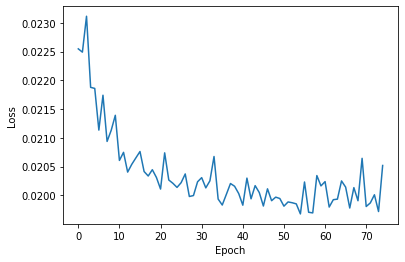

In [100]:
plt.plot([loss.cpu() for loss in loss_log])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

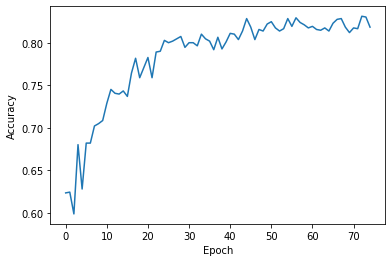

In [101]:
plt.plot(accuracy_log)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

# Prediction

In [102]:
best_checkpoint = TREC_classification_Model(
    vocab_size = vocab_size, 
    embedding_dim = embedding_dim, 
    hidden_size = hidden_size,
    num_layers = num_layers,
    dropout_rate = dropout_rate,
    num_classes = num_class
).to(device)

In [103]:
best_checkpoint.load_state_dict(torch.load("checkpoint.pt"))

<All keys matched successfully>

In [104]:
def predict(text):
    with torch.no_grad():
        text = torch.tensor(vocabulary(tokenizer(text))).to(device)
        output = best_checkpoint(text).to(device)
        
        return output[1].argmax(0).item()

In [105]:
predicted = []
for text in test_data:
    predicted.append(predict(text))

In [106]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

In [107]:
print(f"Accuracy: {accuracy_score(test_labels, predicted):.6f} | Precision: {precision_score(test_labels, predicted, average = 'macro'):.6f} | Recall: {recall_score(test_labels, predicted, average = 'macro'):.6f} | F1 score: {f1_score(test_labels, predicted, average = 'macro'):.6f}")

Accuracy: 0.836000 | Precision: 0.694588 | Recall: 0.708307 | F1 score: 0.700427


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [108]:
list(word2idx.keys())

['LOC', 'HUM', 'DESC', 'ENTY', 'ABBR', 'NUM']

In [109]:
print(classification_report(test_labels, predicted, target_names = list(word2idx.keys())))

              precision    recall  f1-score   support

         LOC       0.79      0.86      0.82        81
         HUM       0.88      0.92      0.90        65
        DESC       0.84      0.90      0.87       138
        ENTY       0.76      0.67      0.71        94
        ABBR       0.00      0.00      0.00         9
         NUM       0.90      0.89      0.90       113

    accuracy                           0.84       500
   macro avg       0.69      0.71      0.70       500
weighted avg       0.82      0.84      0.83       500



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [110]:
print(confusion_matrix(test_labels, predicted))

[[ 70   1   2   7   0   1]
 [  2  60   1   2   0   0]
 [  8   0 124   3   0   3]
 [  5   7  13  63   0   6]
 [  0   0   3   5   0   1]
 [  4   0   5   3   0 101]]


In [111]:
import seaborn as sns

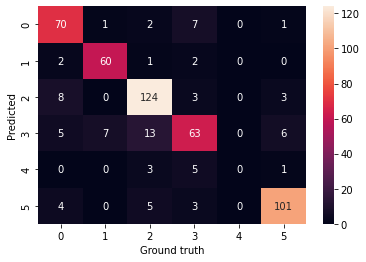

In [112]:
sns.heatmap(confusion_matrix(test_labels, predicted), annot = True, fmt = "g")
plt.ylabel("Predicted")
plt.xlabel("Ground truth")
plt.show()

In [113]:
for text, y_pred, y_truth in zip(test_data[0:10], predicted[0:10], test_labels[0:10]):
    print(f"{text} -- {idx2word[y_pred]} -- {idx2word[y_truth]}")

How far is it from Denver to Aspen ? -- NUM -- NUM
What county is Modesto , California in ? -- ENTY -- LOC
Who was Galileo ? -- HUM -- HUM
What is an atom ? -- DESC -- DESC
When did Hawaii become a state ? -- NUM -- NUM
How tall is the Sears Building ? -- NUM -- NUM
George Bush purchased a small interest in which baseball team ? -- DESC -- HUM
What is Australia 's national flower ? -- ENTY -- ENTY
Why does the moon turn orange ? -- DESC -- DESC
What is autism ? -- DESC -- DESC
